In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [4]:
# load MNIST dataset
import urllib, gzip, pickle

mnistfile = 'mnist.pkl.gz'
if not os.path.isfile(mnistfile):
    url = urllib.request.URLopener()
    url.retrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", mnistfile)
f = gzip.open(mnistfile, 'rb')

training_set, validation_set, testing_set = pickle.load(f, encoding='latin1')

f.close()

X_train,    y_train    = training_set
X_validate, y_validate = validation_set
X_test,     y_test     = testing_set

In [5]:
def reshape_mnist(vectors):
    images = np.reshape(vectors, (-1,28,28,1))
    return images

In [6]:
X_train    = reshape_mnist(X_train)
X_validate = reshape_mnist(X_validate)
X_test     = reshape_mnist(X_test)

In [7]:
def plot_many(images, n=[2,6]):
    plt.figure(figsize=(12,4))
    for i in range(n[0]):
        for j in range(n[1]):
            plt.subplot(n[0], n[1], j*n[0]+i+1)
            plt.imshow(images[np.random.randint(0, images.shape[0]-1),:,:,0], cmap=plt.get_cmap("Greys"))
            plt.axis('off')

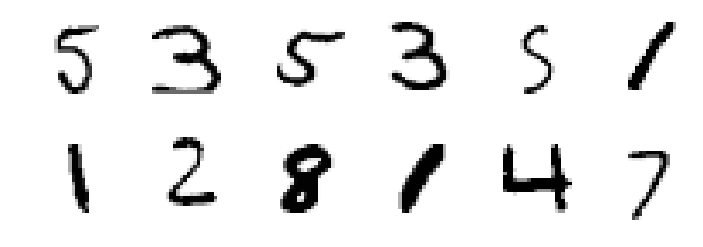

In [8]:
plot_many(X_train)

In [15]:
"""
An implementation of a convolutional autoencoder (CAE) using Keras.
Jason M. Manley, 2018
jmanley@rockefeller.edu
"""

import os
import keras
import numpy as np

class ConvAutoEncoder:

    def __init__(self, input_shape, output_dim, filters=[32, 64, 128, 256],
                 kernel=(3,3), stride=(1,1), strideundo=2, pool=(2,2),
                 optimizer="adamax", lossfn="mse"):
        # For now, assuming input_shape is mxnxc, and m,n are multiples of 2.

        self.input_shape = input_shape
        self.output_dim  = output_dim

        # define encoder architecture
        self.encoder = keras.models.Sequential()
        self.encoder.add(keras.layers.InputLayer(input_shape))
        for i in range(len(filters)):
            self.encoder.add(keras.layers.Conv2D(filters=filters[i], kernel_size=kernel, 
                                                 strides=stride, activation='elu', padding='same'))
            self.encoder.add(keras.layers.MaxPooling2D(pool_size=pool))
        self.encoder.add(keras.layers.Flatten())
        self.encoder.add(keras.layers.Dense(output_dim))

        # define decoder architecture
        self.decoder = keras.models.Sequential()
        self.decoder.add(keras.layers.InputLayer((output_dim,)))
        
        self.decoder.add(keras.layers.Dense((int(input_shape[0]/(2**(len(filters)))) *
                                               int(input_shape[1]/(2**(len(filters)))) * filters[len(filters)-1])))
        self.decoder.add(keras.layers.Reshape((int(input_shape[0]/(2**(len(filters)))),
                                               int(input_shape[1]/(2**(len(filters)))), filters[len(filters)-1])))
        for i in range(1,len(filters)):
            self.decoder.add(keras.layers.Conv2DTranspose(filters=filters[len(filters)-i], kernel_size=kernel, 
                                                          strides=strideundo, activation='elu', padding='same'))
        self.decoder.add(    keras.layers.Conv2DTranspose(filters=input_shape[2],          kernel_size=kernel, 
                                                          strides=strideundo, activation=None,  padding='same'))

        # compile model
        input         = keras.layers.Input(input_shape)
        code          = self.encoder(input)
        reconstructed = self.decoder(code)

        self.ae = keras.models.Model(inputs=input, outputs=reconstructed)
        self.ae.compile(optimizer=optimizer, loss=lossfn)


    def fit(self, train, test, epochs=25, callbacks=[keras.callbacks.BaseLogger()]):

        self.ae.fit(x=train, y=train, epochs=epochs, validation_data=[test, test],
                    callbacks=callbacks)

        self.mse = self.ae.evaluate(test, test)
        print('CAE MSE on validation data: ', self.mse)


    def save_weights(self, path=None, prefix=""):
        if path is None: path = os.getcwd()
        self.encoder.save_weights(os.path.join(path, prefix + "encoder_weights.h5"))
        self.decoder.save_weights(os.path.join(path, prefix + "decoder_weights.h5"))


    def load_weights(self, path=None, prefix=""):
        if path is None: path = os.getcwd()
        self.encoder.load_weights(os.path.join(path, prefix + "encoder_weights.h5"))
        self.decoder.load_weights(os.path.join(path, prefix + "decoder_weights.h5"))


    def encode(self, input):
        return self.encoder.predict(input)


    def decode(self, codes):
        return self.decoder.predict(codes)

In [19]:
# initialize ConvAutoEncoder model
cae = ConvAutoEncoder(input_shape=(X_train.shape[1], X_train.shape[2],1),
                      output_dim=10, filters=[32,64], pool=(3,3))

In [20]:
print(X_train.shape)

(50000, 28, 28, 1)


In [21]:
cae.encoder.summary()
cae.decoder.summary()
cae.ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                5770      
Total params: 24,586
Trainable params: 24,586
Non-trainable params: 0
_________________________________________________________________
______

In [ ]:
# fit to training, validation data
cae.fit(X_train, X_validate, epochs=20)
cae.save_weights()